In [1]:
#import urllib, urllib3
from bs4 import BeautifulSoup
import requests
import time
import io
import numpy as np
#import nltk
#from nltk.corpus import wordnet as wn
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.models.ldamodel import LdaModel

Downloading abstracts and from computer science papers using [arXiv.org](https://arxiv.org) API and group them by years:

In [173]:
import os
import pandas as pd
def load_pickle_df(filename):
    if not os.path.exists(filename):
        print("Error file does not exist")
    else:
        print("Loading file: "+filename)
        return pd.read_pickle(filename)
def combine_pickles_to_df(path):
    for idx,e in enumerate(os.listdir(path)):
        if (e == ".ipynb_checkpoints"):
            continue
        file_path = path+e
        if idx == 0:
            dff = load_pickle_df(file_path)
            print(len(dff))
        else:
            df = load_pickle_df(file_path)
            print(len(df))
            dff = dff.append(df,ignore_index=True)
    return dff

In [178]:
path_pickles = "pickles/"
dff = combine_pickles_to_df(path_pickles)
print("raw:",len(dff))
dff = dff.loc[dff.astype(str).drop_duplicates().index]
print("unduped",len(dff))

Loading file: pickles/arxiv_data_cat_20180815175209_to_20190606175609_1560075418.pickle.bz2
45800
Loading file: pickles/arxiv_data_cat_20000103142511_to_201001010000_1560093236.pickle.bz2
18328
Loading file: pickles/arxiv_data_cat_20170330060449_to_20180323224052_1560076229.pickle.bz2
5970
Loading file: pickles/arxiv_data_cat_19900101000000_to_20000103142511_1560093653.pickle.bz2
1604
Loading file: pickles/arxiv_data_cs_201001010000_to_20170909215812_1560040808.pickle.bz2
49600
Loading file: pickles/arxiv_data_cat_201001010000_to_20120905175052_1560072901.pickle.bz2
24438
Loading file: pickles/arxiv_data_cat_201001010000_to_20151226190200_1560070379.pickle.bz2
50000
raw: 195740
unduped 180644


In [179]:
dff[:1]

,id,updated,published,title,summary,authors,affiliations,doi,journal_ref,pdf_link,primary_category,categories
0,http://arxiv.org/abs/1906.02739v1,2019-06-06T17:56:09Z,2019-06-06T17:56:09Z,Mesh R-CNN,Rapid advances in 2D perception have led to sy...,"[Georgia Gkioxari, Jitendra Malik, Justin John...",[],None,None,http://arxiv.org/pdf/1906.02739v1,cs.CV,[cs.CV]


In [146]:
dff.id[:2][0]

'http://arxiv.org/abs/1906.02739v1'

In [235]:
def clean_id(s):
    if s:
        s = re.sub('.*(abs\/)', '', s)
        s = re.sub('.*(cs\/)', '', s)
        s = re.sub('.*(astro-ph\/)', '', s)
        s = re.sub('.*(math\/)', '', s)
        s = re.sub('.*(org\/)', '', s)
        s = re.sub('.*(dyn\/)', '', s)
        s = re.sub('.*(lg\/)', '', s)
        s = re.sub('.*(mat\/)', '', s)
        s = re.sub('.*(qc\/)', '', s)
        s = re.sub('.*(ph\/)', '', s)
        s = re.sub('.*(qc\/)', '', s)
        s = re.sub('.*(nlin\/)', '', s)
        s = re.sub('.*(th\/)', '', s)
        s = re.sub('.*(bio\/)', '', s)
        s = re.sub('.*(lat\/)', '', s)
        s = re.sub('\..*$', '', s)
        return s.strip()
    return s

dff_ids_y_m = dff.id.map(clean_id)

In [231]:
dff_ids_y_m[:1]

0    1906
Name: id, dtype: object

In [181]:
dff_ids_y_m[0]

'1906'

In [153]:
len(dff_ids_y_m)

160722

In [154]:
s_full = list(dff_ids_y_m)
len(s_full)

160722

In [155]:
s_y_m = list(dff_ids_y_m)
s_y_m[31713]

'0201024v2'

In [182]:
s_y_m_test = list(map(lambda x: x[0:4], dff_ids_y_m))
s_y_m_test[31713]

'0201'

In [186]:
"as" in s_y_m

False

In [194]:
papers_y_m['Year']

0      as
1      ma
2      he
3      cm
4      co
5      nl
6      nu
7      q-
8      ad
9      ch
10     qu
11     10
12     09
13     97
14     04
15     05
16     96
17     95
18     06
19     12
20     94
21     14
22     07
23     18
24     15
25     11
26     16
27     03
28     08
29     17
       ..
268    19
269    06
270    15
271    00
272    01
273    02
274    99
275    13
276    03
277    98
278    14
279    12
280    11
281    15
282    16
283    10
284    17
285    09
286    18
287    08
288    93
289    07
290    94
291    95
292    06
293    05
294    97
295    04
296    19
297    gr
Name: Year, Length: 298, dtype: object

In [237]:
papers_y_m['Year'].where(papers_y_m['Year'] > 50)

0      2017
1      2014
2      2002
3      2012
4      2005
5      2094
6      2011
7      2098
8      2003
9      2010
10     2095
11     2009
12     2096
13     2004
14     2008
15     2007
16     2097
17     2013
18     2006
19     2001
20     2016
21     2018
22     2015
23     2099
24     2000
25     2014
26     2099
27     2000
28     2003
29     2009
       ... 
278    2010
279    2095
280    2002
281    2001
282    2099
283    2002
284    2000
285    2003
286    2017
287    2004
288    2012
289    2018
290    2016
291    2015
292    2019
293    2014
294    2093
295    2094
296    2013
297    2011
298    2098
299    2095
300    2010
301    2009
302    2096
303    2007
304    2006
305    2097
306    2005
307    2008
Name: Year, Length: 308, dtype: int64

In [267]:
s_y_m = list(map(lambda x: x[0:4], dff_ids_y_m))

papers_y_m = pd.DataFrame(columns=['Year', 'Month', 'Papers'])

for i, item in enumerate(set(s_y_m)):
    if s_y_m.count(item) > 1:
        papers_y_m.loc[i, 'Year'] = item[0:2]
        papers_y_m.loc[i, 'Month'] = item[2:4]
        papers_y_m.loc[i, 'Papers'] = s_y_m.count(item)


papers_y_m.sort_values('Year', inplace=True)
papers_y_m.sort_values('Month', inplace=True, ascending=False)
papers_y_m.reset_index(inplace=True, drop=True)
papers_y_m['Year'] = (papers_y_m['Year'].astype(int).where(papers_y_m['Year'].astype(int) < 50, 
                                                           papers_y_m['Year'].astype(int)-100) 
                      + 2000)

papers_y_m

,Year,Month,Papers
0,2017,12,275
1,2014,12,1543
2,2002,12,65
3,2012,12,219
4,2005,12,116
5,1994,12,11
6,2011,12,722
7,1998,12,25
8,2003,12,71
9,2010,12,640


In [100]:
dff_ids.str.slice(stop=2)[60000]

'17'

In [199]:
"as" in s_y

True

64164

In [234]:
piece_to_find = "he"
dff[s_y.index(piece_to_find):s_y.index(piece_to_find)+1]

,id,updated,published,title,summary,authors,affiliations,doi,journal_ref,pdf_link,primary_category,categories
60249,http://arxiv.org/abs/hep-lat/0505005v1,2005-05-09T16:03:21Z,2005-05-09T16:03:21Z,Parallel Programming with Matrix Distributed P...,Matrix Distributed Processing MDP) is a C++ li...,[Massimo Di Pierro],[],None,None,http://arxiv.org/pdf/hep-lat/0505005v1,hep-lat,"[hep-lat, cs.CE, physics.comp-ph]"


In [268]:
s_y = list(map(lambda x: x[0:2], dff_ids_y_m.str.slice(stop=2)))

papers_y = pd.DataFrame(columns=['Year', 'Papers'])

for i, item in enumerate(set(s_y)):
    if s_y.count(item) > 1:
        papers_y.loc[i, 'Year'] = item
        papers_y.loc[i, 'Papers'] = s_y.count(item)

papers_y['Year'] = (papers_y['Year'].astype(int).where(papers_y['Year'].astype(int) < 50, 
                                                           papers_y['Year'].astype(int)-100) 
                      + 2000)
papers_y.sort_values('Year', inplace=True)
papers_y.reset_index(inplace=True, drop=True)
#papers_y['Year'] = papers_y['Year'].astype(int) + 2000
papers_y

,Year,Papers
0,1993,24
1,1994,251
2,1995,257
3,1996,237
4,1997,192
5,1998,332
6,1999,325
7,2000,499
8,2001,602
9,2002,700


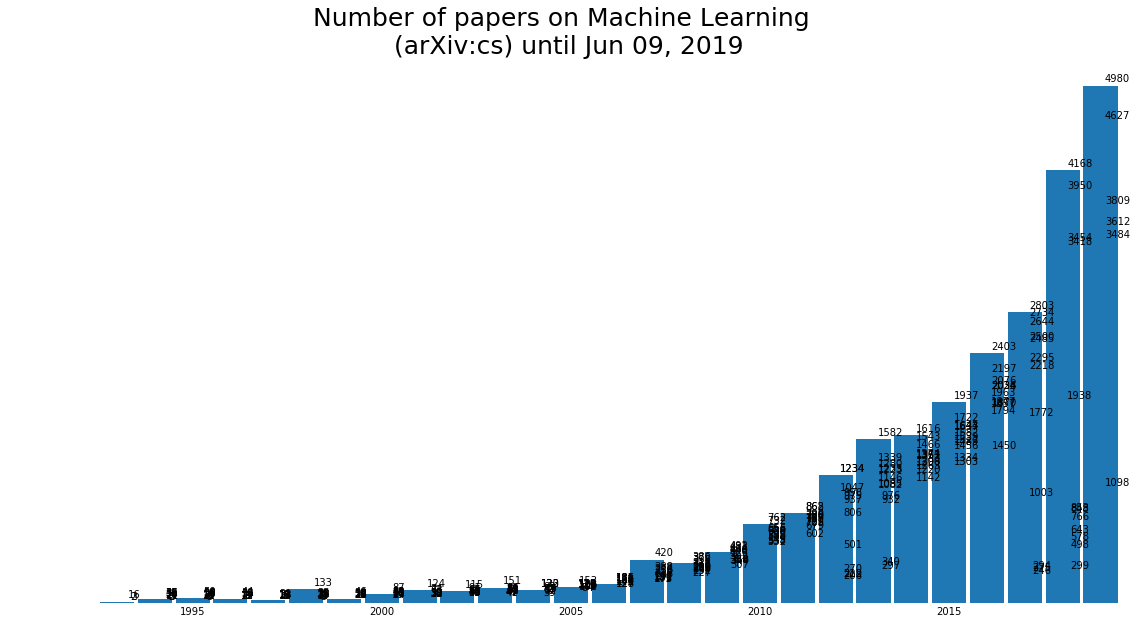

In [300]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,10))
plt.bar(papers_y_m['Year'], papers_y_m['Papers'], width=0.9)
#plt.axis('off')
ax = plt.gca()
ax.set_title("Number of papers on Machine Learning \n (arXiv:cs) until Jun 09, 2019", size=25)
ax.set_xlim(1990.1, 2019.6)

rects = ax.patches
labels = [papers_y_m.loc[i, 'Papers'] for i in range(len(rects))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    rect.set_y = rect.get_y() + 10
    ax.text(rect.get_x() + rect.get_width(), height + 15, label, ha='center', va='bottom', color='black')

ax.tick_params(axis ='x', which='minor', length=0)
ax.tick_params(axis ='both', which='major', length=0)
ax.set_yticklabels = ['']
ax.axes.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig("arxiv_data_cs_all_y_m.png", format="png", transparent=True,rasterized=True,dpi=300)
plt.show()

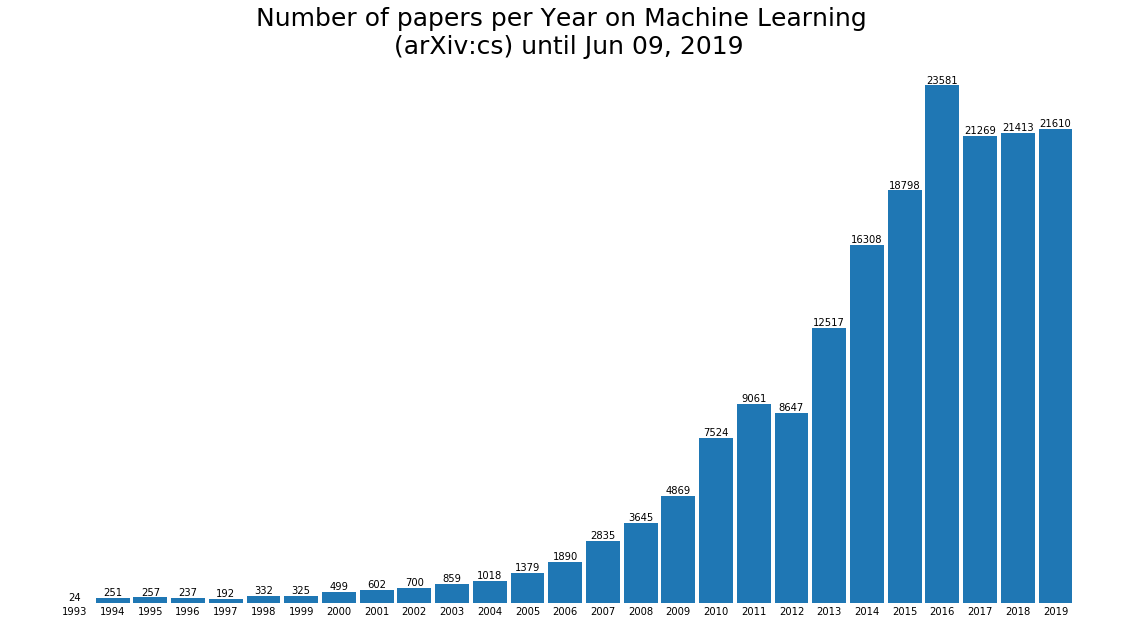

In [301]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,10))
plt.bar(papers_y['Year'], papers_y['Papers'], width=0.9)
#plt.axis('off')
ax = plt.gca()
ax.set_title("Number of papers per Year on Machine Learning \n (arXiv:cs) until Jun 09, 2019", size=25)

max_value = papers_y['Year'].max()
min_value = papers_y['Year'].min()
number_of_steps = 1
l = np.arange(min_value, max_value+1, number_of_steps)
ax.set(xticks=l, xticklabels=l)

rects = ax.patches
labels = [papers_y.loc[i, 'Papers'] for i in range(len(rects))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    rect.set_y(rect.get_y()+10)
    ax.text(rect.get_x() + rect.get_width()/2, height + 15, str(label), ha='center', va='bottom', color='black')

ax.tick_params(axis ='x', which='minor', length=0)
ax.tick_params(axis ='both', which='major', length=0)
ax.set_yticklabels = ['']
ax.axes.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig("arxiv_data_cs_all_y.png", format="png", transparent=True,rasterized=True,dpi=300)
plt.show()

In [298]:
filename = "arxiv_data_cs_all_stats_years.json"
papers_y.to_json(filename)

In [299]:
filename = "arxiv_data_cs_all_stats_years_months.json"
papers_y_m.to_json(filename)